In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import h5py 
import skimage.transform as tf 
%matplotlib inline 

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r") 
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) 
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r") 
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:]) 
        
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0])) # change dimension from (209,) to (1, 209)
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0])) # change (50,) to (1, 50)
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Label[1], This is'cat' 图片.


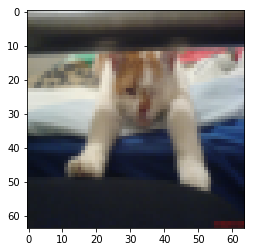

In [4]:
index = 29
plt.imshow(train_set_x_orig[index])
print ("Label" + str(train_set_y[:, index]) + ", This is'" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' 图片.")

In [5]:

print ("train_set_x_orig shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_orig shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_orig shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x_orig shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [6]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = test_set_x_orig.shape[1]

print ("Training sample: m_train = " + str(m_train))
print ("Test sample: m_test = " + str(m_test))
print ("pic dim: num_px = " + str(num_px))

Training sample: m_train = 209
Test sample: m_test = 50
pic dim: num_px = 64


In [7]:
# Flatten and transformation
# dim（pic#，sample#）

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T 

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))

train_set_x_flatten shape: (12288, 209)
test_set_x_flatten shape: (12288, 50)


In [8]:
# Normalization
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [9]:
def sigmoid(z):
    """
    param:
    z -- numbner of num array.
    return:
    s -- apply signoid founction
    """
    s = 1 / (1 + np.exp(-z))    
    return s

In [10]:
def initialize_with_zeros(dim):
    """
    init w and b
    Param:
    dim -- w (12288 * 1)。
    
    return:
    w -- weight
    b -- bias
    """

    w = np.zeros((dim,1))
    b = 0
    
    return w, b

In [11]:
def propagate(w, b, X, Y):
    """
    Param:
    w -- weight (12288, 1)
    b -- bias
    X -- features  (12288, 209)
    Y -- label 0 or 1，0 - no cat，1 - cat，(1,209)

    return:
    cost 
    dw -- w gradient
    db -- b gradient
    """
    
    m = X.shape[1]
    
    # forward propagation
    A = sigmoid(np.dot(w.T, X) + b)                             
    cost = -np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)) / m  
    
    # backward propagation
    dZ = A - Y
    dw = np.dot(X,dZ.T) / m
    db = np.sum(dZ) / m
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [12]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """    
    Param:
    w -- 12288, 1)
    b -- bias
    X -- features (12288, 209)
    Y -- label 0 or 1，0 - no cat，1 - cat，(1,209)

    num_iterations -- optimization time
    learning_rate -- param to control optimization
    print_cost -- print cost for every 100 iteration
    
    return:
    params -- optimized w and b
    costs -- the lower the cost, the opitimal the param
    """
    
    costs = []
    
    for i in range(num_iterations):        
        grads, cost = propagate(w, b, X, Y) # calculate gradient
                
        dw = grads["dw"]
        db = grads["db"]
        
        # gradient descent
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print ("Optimaized %i, cost: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    return params, costs

In [13]:
def predict(w, b, X):
    """    
    Param:
    w -- 12288, 1)
    b -- bias
    X -- features (12288, 209)
    
    return:
    Y_prediction -- results
    """   
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
       
    A = sigmoid(np.dot(w.T, X) + b)  # prediction
    
    for i in range(A.shape[1]):
        if A[0,i] >= 0.5:
            Y_prediction[0,i] = 1
    
    return Y_prediction

In [14]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """    
    Param:
    X_train -- training data (12288, 209)
    Y_train -- training label  (1, 209)
    X_test -- test data (12288, 50)
    Y_test -- test label (1, 50)
    num_iterations 
    learning_rate 
    print_cost 
    
    return:
    d 
    """
    
    # init
    w, b = initialize_with_zeros(X_train.shape[0])

    # train
    parameters, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    # use w and b to predict
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    
    print("training precision: {}%".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test precision: {}%".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [15]:
# use model to train
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Optimaized 0, cost: 0.693147
Optimaized 100, cost: 0.584508
Optimaized 200, cost: 0.466949
Optimaized 300, cost: 0.376007
Optimaized 400, cost: 0.331463
Optimaized 500, cost: 0.303273
Optimaized 600, cost: 0.279880
Optimaized 700, cost: 0.260042
Optimaized 800, cost: 0.242941
Optimaized 900, cost: 0.228004
Optimaized 1000, cost: 0.214820
Optimaized 1100, cost: 0.203078
Optimaized 1200, cost: 0.192544
Optimaized 1300, cost: 0.183033
Optimaized 1400, cost: 0.174399
Optimaized 1500, cost: 0.166521
Optimaized 1600, cost: 0.159305
Optimaized 1700, cost: 0.152667
Optimaized 1800, cost: 0.146542
Optimaized 1900, cost: 0.140872
training precision: 99.04306220095694%
test precision: 70.0%


Label 1, test result 1


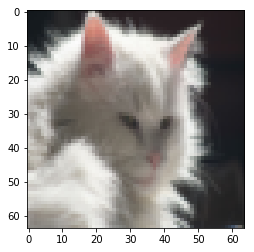

In [16]:
index = 8
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("Label " + str(test_set_y[0,index]) + ", test result " + str(int(d["Y_prediction_test"][0,index])))

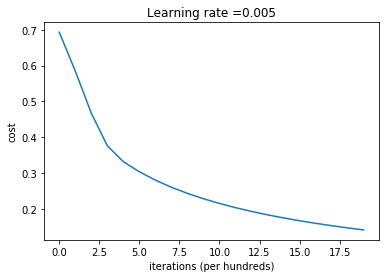

In [17]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)') 
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate: 0.01
training precision: 99.52153110047847%
test precision: 68.0%

-------------------------------------------------------

learning rate: 0.001
training precision: 88.99521531100478%
test precision: 64.0%

-------------------------------------------------------

learning rate: 0.0001
training precision: 68.42105263157895%
test precision: 36.0%

-------------------------------------------------------



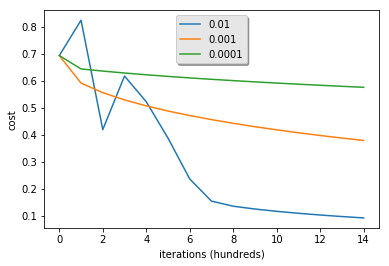

In [18]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate: " + str(i) )
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


results 0


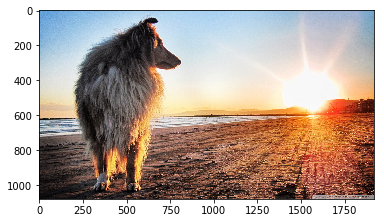

In [19]:
my_image = "dog.jpg" 
fname = "images/" + my_image

image = np.array(plt.imread(fname))
my_image = tf.resize(image,(num_px,num_px), mode='reflect').reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("results " + str(int(np.squeeze(my_predicted_image))))